In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('Dataset/train.csv')
data_test_a = pd.read_csv('Dataset/testA.csv')

In [3]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(data_train.select_dtypes(include=['object']).columns)
label = 'isDefault'
numerical_fea.remove(label)

In [4]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [5]:
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())

# 以下代码没有作用，mode()返回是DataFrame，填充后nan无变化
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode().item())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode().item())

In [6]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [7]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [8]:
for data in [data_train , data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'], format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDt'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [9]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [10]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

for data in [data_train , data_test_a]:      
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [11]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

0.0      64237
1.0      52489
2.0      72358
3.0      64152
4.0      47985
5.0      50102
6.0      37254
7.0      35407
8.0      36192
9.0      30272
10.0    262753
NaN      46799
Name: employmentLength, dtype: int64

In [12]:
data_train['earliesCreditLine'].sample(5)

715351    Jul-1982
95199     Sep-2001
444201    Oct-1977
260128    Dec-1990
391437    Jan-1995
Name: earliesCreditLine, dtype: object

In [13]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [14]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']

In [15]:
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


In [16]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [17]:
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [18]:
def find_outliers_by_3segama(data, fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea + '_outliers'] = data[fea].apply(lambda x: str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [19]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train, fea)
    print(data_train[fea + '_outliers'].value_counts())
    print(data_train.groupby(fea + '_outliers')['isDefault'].sum())
    print('*' * 10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

In [20]:
for fea in numerical_fea:
    data_train = data_train[data_train[fea + '_outliers'] == '正常值']
    data_train = data_train.reset_index(drop=True)

In [21]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [22]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

In [23]:
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

In [24]:
temp_dict = data_train.groupby('grade')['isDefault'].mean().reset_index().rename(columns={'isDefault': 'grade_target_mean'})

In [25]:
temp_dict = dict(zip(temp_dict['grade'], temp_dict['grade_target_mean']))

In [26]:
data_train['grade_target_mean'] = data_train['grade'].map(temp_dict)
data_test_a['grade_target_mean'] = data_test_a['grade'].map(temp_dict)

In [27]:
temp_dict = data_train.groupby('subGrade')['isDefault'].mean().reset_index().rename(columns={'isDefault': 'subGrade_target_mean'})
temp_dict = dict(zip(temp_dict['subGrade'], temp_dict['subGrade_target_mean']))
data_train['subGrade_target_mean'] = data_train['subGrade'].map(temp_dict)
data_test_a['subGrade_target_mean'] = data_test_a['subGrade'].map(temp_dict)


In [28]:
data_test_a

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n8,n9,n10,n11,n12,n13,n14,issueDateDt,grade_target_mean,subGrade_target_mean
0,800000,14000.0,3,10.99,458.28,2,B3,7027.0,10.0,0,...,19.0,6.0,17.0,0.0,0.0,1.0,3.0,2587,0.131210,0.128111
1,800001,20000.0,5,14.65,472.14,3,C5,60426.0,10.0,0,...,9.0,3.0,5.0,0.0,0.0,2.0,2.0,2952,0.224522,0.262219
2,800002,12000.0,3,19.99,445.91,4,D4,23547.0,2.0,1,...,6.0,4.0,12.0,0.0,0.0,0.0,7.0,3410,0.304227,0.325175
3,800003,17500.0,5,14.31,410.02,3,C4,636.0,4.0,0,...,14.0,2.0,10.0,0.0,0.0,0.0,3.0,2710,0.224522,0.251584
4,800004,35000.0,3,17.09,1249.42,4,D1,368446.0,0.0,1,...,18.0,11.0,19.0,0.0,0.0,0.0,1.0,3775,0.304227,0.279444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,999995,7000.0,3,11.14,229.64,2,B2,330967.0,7.0,1,...,6.0,2.0,8.0,0.0,0.0,0.0,4.0,1949,0.131210,0.109461
199996,999996,6000.0,3,6.24,183.19,1,A2,38930.0,1.0,1,...,13.0,6.0,25.0,0.0,0.0,0.0,0.0,3044,0.059838,0.044493
199997,999997,14000.0,5,15.88,339.57,3,C4,282016.0,8.0,2,...,42.0,13.0,21.0,0.0,0.0,0.0,0.0,2222,0.224522,0.251584
199998,999998,8000.0,3,18.06,289.47,4,D2,97.0,4.0,1,...,19.0,6.0,11.0,0.0,0.0,0.0,2.0,3775,0.304227,0.298190


In [29]:
data_train

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers,grade_target_mean,subGrade_target_mean
0,0,35000.0,5,19.52,917.97,5,E2,320.0,2.0,2,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.386234,0.380444
1,1,18000.0,5,18.49,461.90,4,D2,219843.0,5.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.298190
2,2,12000.0,5,16.99,298.17,4,D3,31698.0,8.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.302541
3,6,2050.0,3,7.69,63.95,1,A4,180083.0,9.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.059838,0.065532
4,7,11500.0,3,14.98,398.54,3,C3,214017.0,1.0,1,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.224686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612737,799994,15000.0,5,19.52,393.42,5,E2,29191.0,7.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.386234,0.380444
612738,799995,25000.0,3,14.49,860.41,3,C4,2659.0,7.0,1,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.251584
612739,799997,6000.0,3,13.33,203.12,3,C3,2582.0,10.0,1,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.224686
612740,799998,19200.0,3,6.92,592.14,1,A4,151.0,10.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.059838,0.065532


In [30]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDt', 'id_outliers',
       'loanAmnt_outliers', 'term_outliers', 'interestRate_outliers',
       'installment_outliers', 'employmentTitle_outliers',
       'homeOwnership_outliers', 'annualIncome_outliers',
       'verificationStatus_outliers', 'purpose_outliers', 'postCode_outliers',
       'regionCode_outliers', 'dti_outliers', 'delinquency_2years_outliers',
       '

In [31]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [32]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:05<00:00,  1.27s/it]Label Encoding 完成



In [33]:
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [34]:
# 纵向用缺失值上面的值替换缺失值
data_train = data_train.fillna(axis=0, method='ffill')

In [35]:
x_train = data_train.drop(['isDefault'], axis=1)

In [36]:
data_corr = x_train.corrwith(data_train.isDefault)
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [37]:
numerical_fea = data_train.select_dtypes(include=['number']).columns

In [38]:
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

<AxesSubplot:>

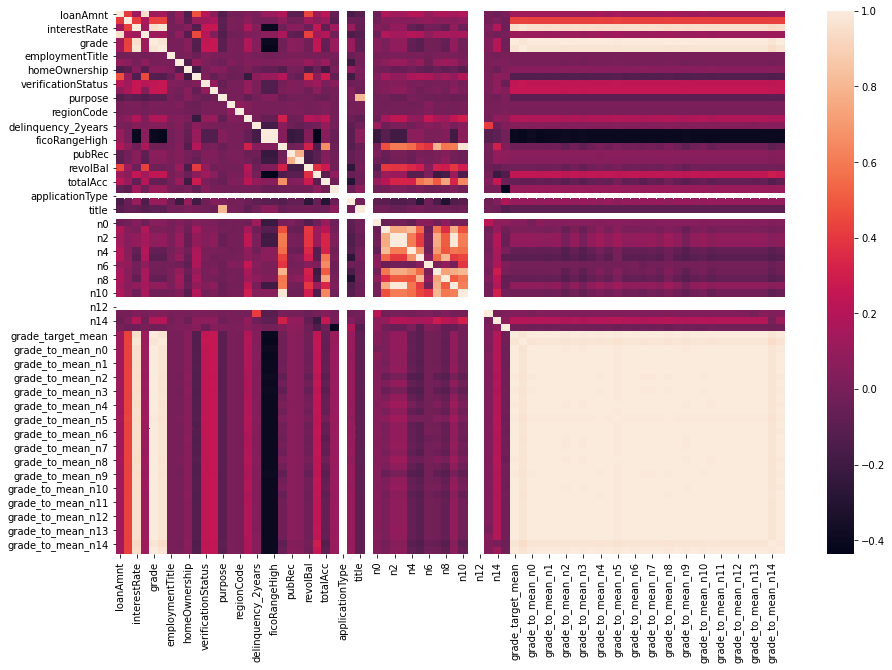

In [39]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation)

In [40]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [41]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=10, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        print(valid_index)
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [42]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [42]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749114	valid_1's auc: 0.729275
[400]	training's auc: 0.764716	valid_1's auc: 0.730125
[600]	training's auc: 0.778489	valid_1's auc: 0.729928
Early stopping, best iteration is:
[446]	training's auc: 0.768137	valid_1's auc: 0.730186
[0.7301862239949224]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748999	valid_1's auc: 0.731035
[400]	training's auc: 0.764879	valid_1's auc: 0.731436
[600

In [61]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[17:38:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69955	eval-auc:0.69714
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[9]	train-auc:0.70637	eval-auc:0.70408
[     7     15     16 ... 612733 612738 612741]
[0.7040851479095191]
************************************ 2 ************************************
[17:39:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due

In [2]:
data_train['sample'] = 'train'
data_test_a['sample'] = 'test'
df_base = pd.concat([data_train, data_test_a], axis=0)

NameError: name 'data_train' is not defined

In [1]:
df_base.to_csv('Dataset/data_for_model.csv', index=False)

NameError: name 'df_base' is not defined